# Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
import logging
from pathlib import Path

from PIL import Image
from google import genai

import tt

LOG = logging.getLogger(__name__)
tt.logging_init()

In [13]:
CLASSES = [
    "chicken",
    "cow",
    "creeper",
    "enderman",
    "pig",
    "player",
    "sheep",
    "skeleton",
    "spider",
    "villager",
    "zombie",
]
CLASSES.sort()
CLASSES_MINECRAFT = [f"minecraft {x}" for x in CLASSES]

flash = "gemini-2.5-flash"
flash_lite = "gemini-2.5-flash-lite"
prompt_short = f"""Detect {", ".join(CLASSES)}. Return AT MOST 20 detections."""

mobs_path = Path.home() / "src/data/mobs1/640"

# File upload

In [ ]:
gf = tt.GeminiFileAPI()
# gf.upload_dir(mobs_path)
gf.sync()
print(gf.gfiles)

[13:35:45]:[INFO]:(httpx): HTTP Request: GET https://generativelanguage.googleapis.com/v1beta/files "HTTP/1.1 200 OK"
[13:35:45]:[INFO]:(httpx): HTTP Request: GET https://generativelanguage.googleapis.com/v1beta/files?pageToken=ciEKD4IBDAix55_IBhCwwZ2OAwoOQgxnc3ljeDY0dDloZGE "HTTP/1.1 200 OK"
[13:35:46]:[INFO]:(httpx): HTTP Request: GET https://generativelanguage.googleapis.com/v1beta/files?pageToken=ciAKDoIBCwie55_IBhCoi_B6Cg5CDHlrM2FwY3Q1eG56eg "HTTP/1.1 200 OK"
[13:35:46]:[INFO]:(httpx): HTTP Request: GET https://generativelanguage.googleapis.com/v1beta/files?pageToken=ciEKD4IBDAiN55_IBhCQtbbJAwoOQgw4b3ZzaTIxdzN6a2E "HTTP/1.1 200 OK"
[13:35:46]:[INFO]:(httpx): HTTP Request: GET https://generativelanguage.googleapis.com/v1beta/files?pageToken=ciAKDoIBCwj85p_IBhCghuJtCg5CDDFneG4zZjExdTg0Zw "HTTP/1.1 200 OK"
[13:35:46]:[INFO]:(httpx): HTTP Request: GET https://generativelanguage.googleapis.com/v1beta/files "HTTP/1.1 200 OK"
[13:35:46]:[INFO]:(httpx): HTTP Request: GET https://generativ

[File(
  create_time=datetime.datetime(2025, 11, 3, 0, 13, 53, 531139, tzinfo=TzInfo(0)),
  display_name='/Users/joe/src/data/mobs1/640/ff14c8a4-2024-10-20_22.23.01.png',
  expiration_time=datetime.datetime(2025, 11, 5, 0, 13, 53, 210265, tzinfo=TzInfo(0)),
  mime_type='image/png',
  name='files/u2r50st3vorl',
  sha256_hash='NjEyMmFkN2ExZjk3NTUwZWRkMzczZjcxN2ZiYzkyMTBjMjJiMjhhODRkNmE0MjEzYTE4NzVjYTQxNzJiZmI3ZA==',
  size_bytes=467090,
  source=<FileSource.UPLOADED: 'UPLOADED'>,
  state=<FileState.ACTIVE: 'ACTIVE'>,
  update_time=datetime.datetime(2025, 11, 3, 0, 13, 53, 531139, tzinfo=TzInfo(0)),
  uri='https://generativelanguage.googleapis.com/v1beta/files/u2r50st3vorl'
), File(
  create_time=datetime.datetime(2025, 11, 3, 0, 13, 51, 937627, tzinfo=TzInfo(0)),
  display_name='/Users/joe/src/data/mobs1/640/f21b358a-2024-10-20_22.22.12.png',
  expiration_time=datetime.datetime(2025, 11, 5, 0, 13, 51, 654292, tzinfo=TzInfo(0)),
  mime_type='image/png',
  name='files/leiqy8dzrqgu',
  sha2

# 

# Detect

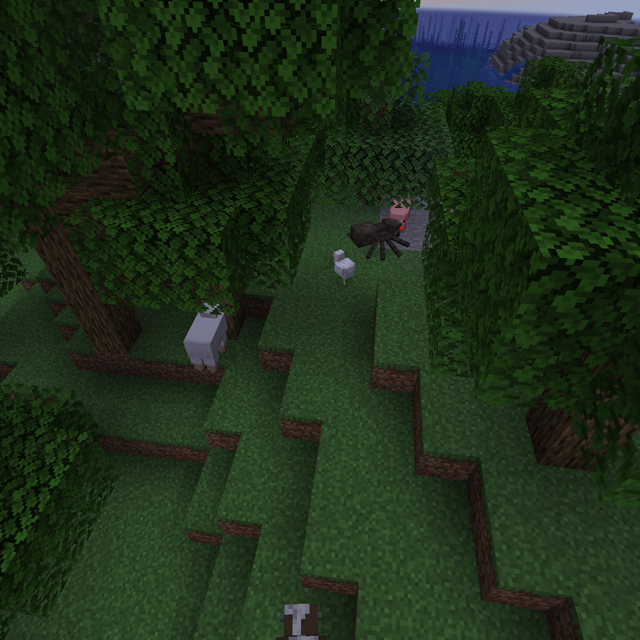

[15:45:30]:[INFO]:(google_genai.models): AFC is enabled with max remote calls: 10.
[15:45:32]:[INFO]:(httpx): HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash:generateContent "HTTP/1.1 200 OK"
[15:45:32]:[INFO]:(tt): RESPONSE len=219 [
  {"box_2d": [324, 537, 405, 630], "label": "spider"},
  {"box_2d": [389, 516, 444, 553], "label": "chicken"},
  {"box_2d": [310, 599, 354, 647], "label": "pig"},
  {"box_2d": [472, 288, 578, 356], "label": "sheep"}
]


[BBox(xyxyn=(0.537, 0.324, 0.63, 0.405), label='spider'), BBox(xyxyn=(0.516, 0.389, 0.553, 0.444), label='chicken'), BBox(xyxyn=(0.599, 0.31, 0.647, 0.354), label='pig'), BBox(xyxyn=(0.288, 0.472, 0.356, 0.578), label='sheep')]


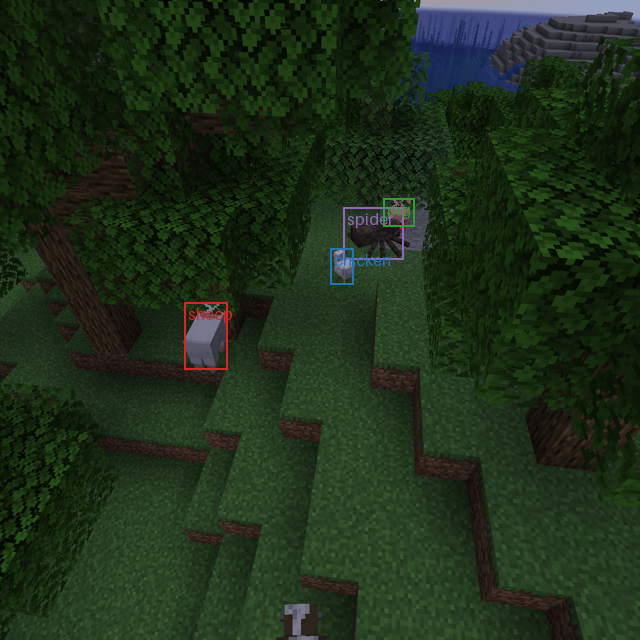

[15:45:32]:[INFO]:(google_genai.models): AFC is enabled with max remote calls: 10.
[15:45:35]:[INFO]:(httpx): HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-lite:generateContent "HTTP/1.1 200 OK"
[15:45:35]:[INFO]:(tt): RESPONSE len=1048 [
  {"box_2d": [356, 500, 456, 575], "label": "chicken"},
  {"box_2d": [429, 237, 570, 350], "label": "sheep"},
  {"box_2d": [310, 587, 383, 650], "label": "pig"},
  {"box_2d": [306, 587, 400, 650], "label": "pig"},
  {"box_2d": [306, 587, 400, 650], "label": "pig"},
  {"box_2d": [306, 587, 400, 650], "label": "pig"},
  {"box_2d": [306, 587, 400, 650], "label": "pig"},
  {"box_2d": [306, 587, 400, 650], "label": "pig"},
  {"box_2d": [306, 587, 400, 650], "label": "pig"},
  {"box_2d": [306, 587, 400, 650], "label": "pig"},
  {"box_2d": [306, 587, 400, 650], "label": "pig"},
  {"box_2d": [306, 587, 400, 650], "label": "pig"},
  {"box_2d": [306, 587, 400, 650], "label": "pig"},
  {"box_2d": [306, 587, 400, 650]

[BBox(xyxyn=(0.5, 0.356, 0.575, 0.456), label='chicken'), BBox(xyxyn=(0.237, 0.429, 0.35, 0.57), label='sheep'), BBox(xyxyn=(0.587, 0.31, 0.65, 0.383), label='pig'), BBox(xyxyn=(0.587, 0.306, 0.65, 0.4), label='pig'), BBox(xyxyn=(0.587, 0.306, 0.65, 0.4), label='pig'), BBox(xyxyn=(0.587, 0.306, 0.65, 0.4), label='pig'), BBox(xyxyn=(0.587, 0.306, 0.65, 0.4), label='pig'), BBox(xyxyn=(0.587, 0.306, 0.65, 0.4), label='pig'), BBox(xyxyn=(0.587, 0.306, 0.65, 0.4), label='pig'), BBox(xyxyn=(0.587, 0.306, 0.65, 0.4), label='pig'), BBox(xyxyn=(0.587, 0.306, 0.65, 0.4), label='pig'), BBox(xyxyn=(0.587, 0.306, 0.65, 0.4), label='pig'), BBox(xyxyn=(0.587, 0.306, 0.65, 0.4), label='pig'), BBox(xyxyn=(0.587, 0.306, 0.65, 0.4), label='pig'), BBox(xyxyn=(0.587, 0.306, 0.65, 0.4), label='pig'), BBox(xyxyn=(0.587, 0.306, 0.65, 0.4), label='pig'), BBox(xyxyn=(0.587, 0.306, 0.65, 0.4), label='pig'), BBox(xyxyn=(0.587, 0.306, 0.65, 0.4), label='pig'), BBox(xyxyn=(0.587, 0.306, 0.65, 0.4), label='pig'), BB

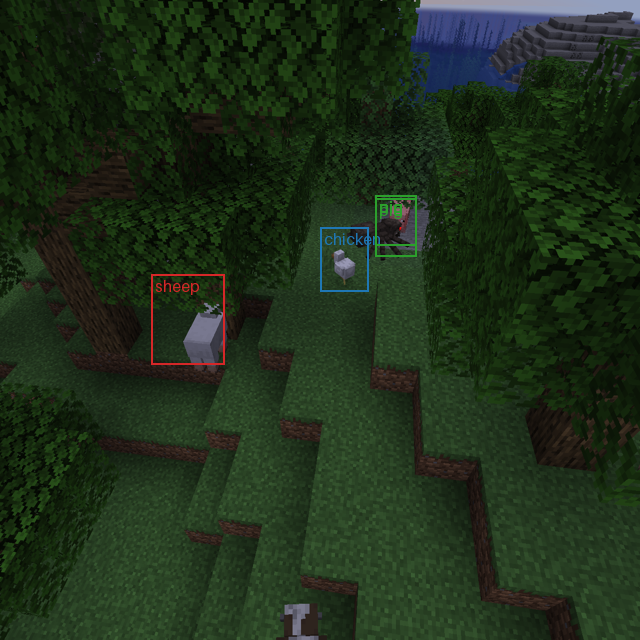

In [ ]:
# image640 = Image.open(mobs_path / "06092b21-2024-10-20_22.22.09.png")
# image640 = Image.open(sorted(mobs_path.glob("*.png"))[5])
# This image causes gemini-2.5-flash-lite to detect the pig repeatedly.
image_break = "/Users/joe/src/data/mobs1/640/cda62cfe-2024-10-20_22.22.31.png"
image640 = Image.open(image_break)
display(image640)
bbox = tt.gemini_detect(image640, prompt_short, model=flash)
print(bbox)
display(tt.plot_bb(image640, bbox, CLASSES))

bbox = tt.gemini_detect(image640, prompt_short, model=flash_lite)
print(bbox)
display(tt.plot_bb(image640, bbox, CLASSES))

In [ ]:
def detect_gfiles(gf: genai.types.File) -> tuple[Image.Image, str]:
    assert isinstance(gf.display_name, str)
    image_file = gf.display_name
    bbs = tt.gemini_detect(gf, prompt_short)
    ann_image = tt.plot_bb(Image.open(image_file), bbs, CLASSES)
    return ann_image, image_file
    
gf.sync()
tt.InferViewer[genai.types.File](detect_gfiles, gf.gfiles).show_widget()

In [8]:
def multi_detect(gf_api: tt.GeminiFileAPI, n: int = 10) -> list[tt.Image]:
    gfiles = gf_api.gfiles[:n]
    results: list[tt.Image] = []
    for i, gfile in enumerate(gfiles):
        LOG.info(f"Detect {i+1}/{len(gfiles)} file={gfile.display_name}")
        assert gfile.display_name is not None
        bbs = tt.gemini_detect(gfile, prompt_short)
        results.append(tt.Image(gfile.display_name, bbs))
    return results

results = multi_detect(gf, 10)

[15:31:01]:[INFO]:(__main__): Detect 1/10 file=/Users/joe/src/data/mobs1/640/ff14c8a4-2024-10-20_22.23.01.png
[15:31:01]:[INFO]:(google_genai.models): AFC is enabled with max remote calls: 10.
[15:31:03]:[INFO]:(httpx): HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-lite:generateContent "HTTP/1.1 200 OK"
[15:31:03]:[INFO]:(tt): RESPONSE len=56 [
  {"box_2d": [168, 245, 540, 557], "label": "sheep"}
]
[15:31:03]:[INFO]:(__main__): Detect 2/10 file=/Users/joe/src/data/mobs1/640/f21b358a-2024-10-20_22.22.12.png
[15:31:03]:[INFO]:(google_genai.models): AFC is enabled with max remote calls: 10.
[15:31:05]:[INFO]:(httpx): HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-lite:generateContent "HTTP/1.1 200 OK"
[15:31:05]:[INFO]:(tt): RESPONSE len=153 [
  {"box_2d": [417, 0, 485, 54], "label": "pig"},
  {"box_2d": [489, 0, 708, 304], "label": "pig"},
  {"box_2d": [396, 577, 437, 647], "label": "cow"}
]
[15:31

JSONDecodeError: Unterminated string starting at: line 1929 column 4 (char 100245)